# Data Container and Core Structures — Usage Guide

This notebook introduces the **core basic structures** used throughtout the ChestXSim simulation pipeline. It shows how to: 
- Represent a volume using `volumeData` and track its attributes and processing history with `MetadataContainer`.
- Define an acquisition geometry that models the real imaging system using the `Geometry` abstract class and its concrete implementation `TomoGeometry` for **Digital Chest Tomosynthesis (DCT)** — and how this structure can be extended to other modalities.
- Configure an X-ray source model using `SourceSpectrum`, load spectral data from the materials folder, and extend it with custom spectra when needed.
- Access **material attenuation coefficients (MAC)** via `MacRepo` for use in unit conversion and polychromatic simulations.


## Overview
ChestXSim relies on a few key data abstractions to keep all stages of the pipeline consistent — from reading CT volumes to simulating projections and spectral effects:

| Class                   | Purpose                   | Description                                                                                                                                                                                                           |
| ----------------------- | ------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`volumeData`**        | Volume container          | Holds the 3D or 4D image array (NumPy/CuPy) and an attached `MetadataContainer`. Acts as the standard data unit passed between processing steps in a simulation pipeline                                                                     |
| **`MetadataContainer`** | Metadata registry         | Stores voxel size, dimensions, acquisition details, and a log (`step_outputs`) of all preprocessing or simulation steps applied to the volume.                                                                        |
| **`Geometry`**          | System geometry              | Abstract base class describing imaging geometry (detector size, pixel size, source-to-detector distance). A concrete implementation for  **DCT** is provided |
| **`SourceSpectrum`**    | X-ray emission model      | Defines the energy distribution of the X-ray source. Loads `.mat` spectrum files automatically from the `materials/spectra/` folder or a user-specified path. Supports mono- and poly-chromatic modes.                |
| **`MACRepo`**           | Material attenuation data | Provides access to **mass attenuation coefficient (MAC)** curves for common materials (e.g., water, soft tissue, bone) from the the `materials/mac/` folder. Used in unit conversion (HU → μ) and polychromatic beam hardening simulations.                |


## VolumeData and MetadataContainer
The `volumeData` class stores a 3D or 4D array volume together with its associated `MetadataContainer`.  The volume can be a NumPy or CuPy array. The unified `xp` backend automatically uses CuPy when a GPU is available, and NumPy otherwise.

This basic example shows how to create a simple array volume, wrap it into a `volumeData` instance, and record a basic crop operation in the metadata for tracking.


GPU detected: Using CuPy with 1 device(s), current device: 0
Original volume shape: (128, 128, 64)
Cropped volume shape : (80, 80, 48)
Voxel size (mm): (0.8, 0.8, 1.0)


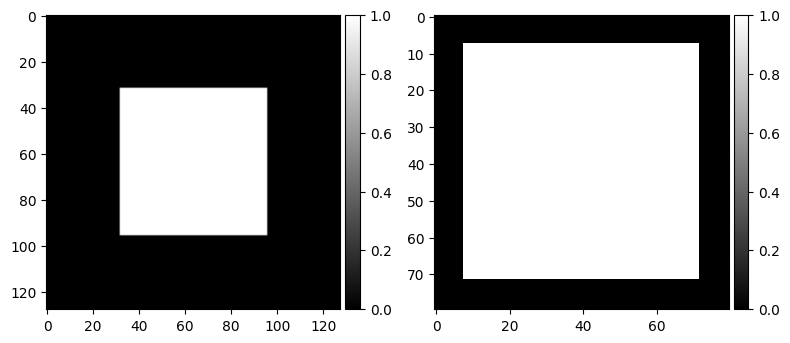

In [1]:
from chestxsim.core.data_containers import volumeData, MetadataContainer
from chestxsim.core.device import xp
from chestxsim.utility.visualization import plot


# --- 1. Create a synthetic 3D volume ---
vol = xp.zeros((128, 128, 64), dtype=xp.float32)
vol[32:96, 32:96, 16:48] = 1.0  # white cube in the center

# --- 2. Create a metadata object ---
md = MetadataContainer(
    dim=vol.shape,
    voxel_size=(0.8, 0.8, 1.0),
    id="Example_CT"
)

# --- 3. Crop operation (simulate a preprocessing step) ---
# To keep the cube centered, crop symmetrically around it with some margin
crop_slices = (slice(24, 104), slice(24, 104), slice(8, 56))
vol_cropped = vol[crop_slices]

# Record the crop operation in metadata
md.step_outputs["CropOperation"] = {
    "crop_indices": [(24, 104), (24, 104), (8, 56)],
    "method": "manual numpy slicing"
}

# --- 4. Wrap into a volumeData object ---
ct = volumeData(volume=vol_cropped, metadata=md)

print("Original volume shape:", vol.shape)
print("Cropped volume shape :", ct.volume.shape)
print("Voxel size (mm):", ct.metadata.voxel_size)

# --- 5. Visualize original and cropped slices ---
# ----Note: Use `.get()` when using a GPU backend (CuPy) to bring the array to CPU for plotting
plot(vol.get()[:, :, 32], ct.volume.get()[:, :, 24])



> **Note:** You can inspect recorded steps using the `metadata.show_steps()` method.

In [2]:
ct.metadata.show_steps()


--- Simulation Steps ---
CropOperation: {'crop_indices': [(24, 104), (24, 104), (8, 56)], 'method': 'manual numpy slicing'}


## System Geometry 

The `Geometry` abstract class defines common acquisition parameters of any simulated imaging system, such as:
- `detector_size`– detector width and height (pixels)
- `pixel_size`– pixel spacing (mm)
- `binning_proj` – projection binning factor


Concrete geometries extend this base by adding **modality-specific attributes** through dedicated mixins (e.g., linear or circular trajectories, cone or fan-beam models).

For Digital Chest Tomosynthesis (DCT), the `TomoGeometry` class models a vertical cone-beam scan, where the source moves along a straight path while the detector remains fixed.
It introduces DCT-specific fields:

- `bucky` – source–object spacing (mm)
- `SDD` – source–detector spacing (mm)
- `step ` – vertical displacement per projection (mm)
- `nstep` – number of source positions

Below is an example configuration representing a common DCT setup with 61 projections:


In [3]:
from chestxsim.core.geometries import TomoGeometry

geo = TomoGeometry(
    detector_size=(4288, 4288),   # pixels (width, height)
    pixel_size=(0.1, 0.1),        # mm/pixel
    binning_proj=4,               # 4x downsampling
    SDD=1800,                     # source–detector distance (mm)
    bucky=14.47,                  # bucky-to-detector distance  (mm)
    step_mm=16.077,               # mm per projection step
    nprojs=61                     # total number of steps
)

print("Modality:", geo.modality)
print("Beam:", geo.beam)
print("Detector (binned):", (geo.W, geo.H))
print("Pixel size (binned):", (geo.pxW, geo.pxH), "mm")
print("Projections:", geo.nprojs)
print("Step:", geo.step_mm, "mm")
print("SDD:", geo.SDD)
print("Bucky:", geo.bucky)

Modality: Modality.TOMO
Beam: BeamGeom.CONE
Detector (binned): (1072, 1072)
Pixel size (binned): (0.4, 0.4) mm
Projections: 61
Step: 16.077 mm
SDD: 1800
Bucky: 14.47


> **Note:** ChestXSim uses a consistent 3D coordinate convention defined as (x, y, z):
> - `x` → left–right direction, aligned with the detector width.
> - `y` → front–back direction (chest to spine).
> - `z` → top–bottom direction, aligned with the detector height
>



A geometry object can also be initialized from a dictionary using the class method  `.from_dict()` 

In [4]:
from chestxsim.core.geometries import TomoGeometry

geom_dict = {
    "detector_size": [4288, 4288],   # pixels
    "pixel_size": [0.1, 0.1],        # mm
    "binning_proj": 4,
    "SDD": 1800,                     # source–detector distance (mm)
    "bucky": 14.47,                  # source–object spacing (mm)
    "step_mm": 16.077,               # vertical step per projection
    "nprojs": 61                     # total projections
}

geo = TomoGeometry.from_dict(geom_dict)

print("Modality:", geo.modality)
print("Beam:", geo.beam)
print("Detector (binned):", (geo.W, geo.H))
print("Pixel size (binned):", (geo.pxW, geo.pxH), "mm")
print("Projections:", geo.nprojs)
print("Step:", geo.step_mm, "mm")
print("SDD:", geo.SDD)
print("Bucky:", geo.bucky)


Modality: Modality.TOMO
Beam: BeamGeom.CONE
Detector (binned): (1072, 1072)
Pixel size (binned): (0.4, 0.4) mm
Projections: 61
Step: 16.077 mm
SDD: 1800
Bucky: 14.47


## Source Spectrum
The X-ray source is defined using the `SourceSpectrum`class, which handles **automatic loading of X-ray spectra**  and supports both polychromatic and monochromatic modes.
The main attributes are: 

- `I0`: X-ray beam intensity (photons/px)
- `voltage`: tube voltage in kVp (e.g., 80, 100, 120).
- `poly_flag` – defines the simulation mode.
    -  If **True** → polychromatic mode: uses the full normalized spectrum across **all energy bins**.
    -  If **False** → monochromatic mode: collapses the spectrum to a single energy bin at `effective_energy`, simulating an idealized single-energy beam.
- `effective_energy` – energy value used for monochromatic simulations. It can be specified manually or computed internally.
- `specter_path` – optional custom path to the spectrum file `.mat`

By default, `.mat` files for standard tube voltages are provided in the materials folder (downloaded from the [SPEKTR MATLAB tool](https://github.com/I-STAR/SPEKTR)) with the naming convention:
`materials / spectra / f"spectr{voltage}kVp.mat"`

The `spectrum` property automaticlly loads and chaches the spectrum data.   


[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr120kVp.mat
[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr120kVp.mat


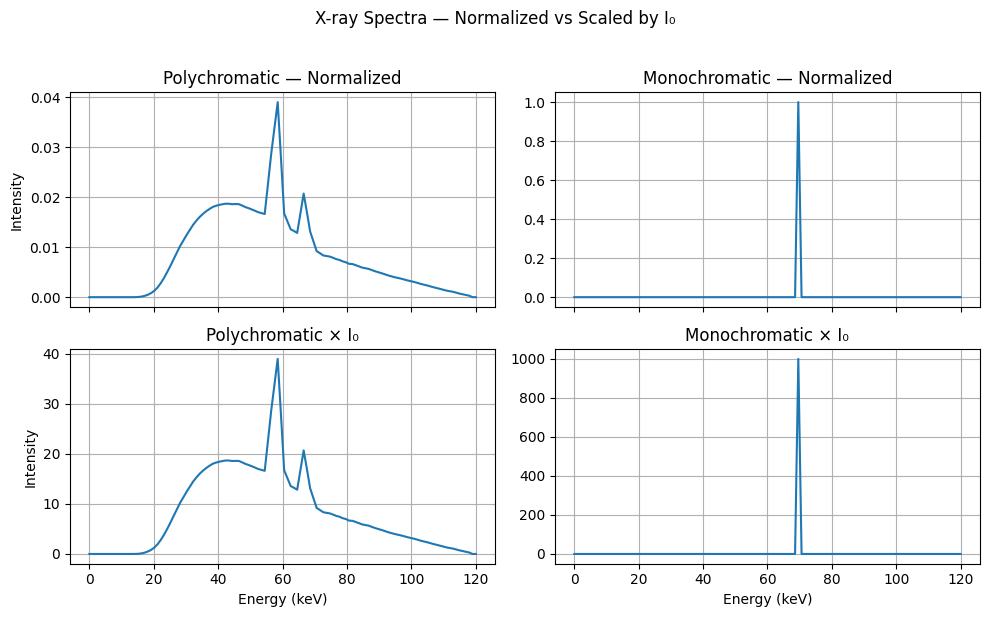

In [5]:
from chestxsim.core.data_containers import SourceSpectrum
import matplotlib.pyplot as plt

# --- Helper ---
to_cpu = lambda a: a.get() if hasattr(a, "get") else a

# --- Define sources ---
spoly = SourceSpectrum(I0=1e3, voltage=120, poly_flag=True)
smono = SourceSpectrum(I0=1e3, voltage=120, poly_flag=False, effective_energy=70)

# --- Get data ---
poly, mono = spoly.spectrum.get(), smono.spectrum.get()
energy = to_cpu(xp.linspace(0, 120, len(poly)))
poly_n, mono_n = to_cpu(poly), to_cpu(mono)
poly_s, mono_s = to_cpu(spoly.I0 * poly), to_cpu(smono.I0 * mono)

# --- Visualization ---
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
titles = [["Polychromatic — Normalized", "Monochromatic — Normalized"],
          ["Polychromatic × I₀", "Monochromatic × I₀"]]
data = [[poly_n, mono_n], [poly_s, mono_s]]

for i in range(2):
    for j in range(2):
        ax[i, j].plot(energy, data[i][j])
        ax[i, j].set_title(titles[i][j])
        ax[i, j].grid(True)
        if i == 1: ax[i, j].set_xlabel("Energy (keV)")
        if j == 0: ax[i, j].set_ylabel("Intensity")

fig.suptitle("X-ray Spectra — Normalized vs Scaled by I₀", y=1.02)
plt.tight_layout()
plt.show()


In [6]:
print(f"Polychromatic: I₀ × sum(normalized) = {poly_s.sum():.3e}")
print(f"Monochromatic: I₀ × sum(normalized) = {mono_s.sum():.3e}")

Polychromatic: I₀ × sum(normalized) = 1.000e+03
Monochromatic: I₀ × sum(normalized) = 1.000e+03


## Mass Attenuation Coefficients 

The `MACRepo` class gives access to attenuation coefficient curves used for unit conversions and polychromatic simulations. The data are stored as plain `.txt` files in the materials folder (downloaded from the [SPEKTR MATLAB tool](https://github.com/I-STAR/SPEKTR)), following the naming convention:
`materials/mac/mac_{material}.txt`
(e.g.,` mac_water.txt`, `mac_bone.txt`, `mac_soft.txt`)

Each file contains attenuation values for approximately **150 energy levels** in ascending keV in  cm²/g.  

To access to built-in materials use **dot-access** like: 

[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac


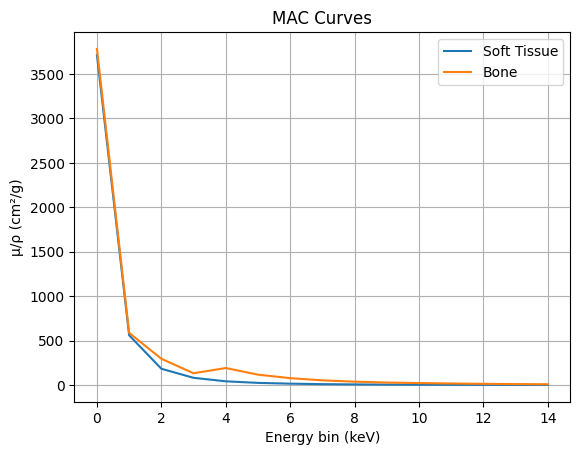

In [7]:
from chestxsim.core.data_containers import MACRepo
import matplotlib.pyplot as plt

# --- Initialize the MAC repository ---
macs = MACRepo()

# --- Access predefined materials ---
soft  = macs.soft
bone  = macs.bone

# --- Plot available curves ---
for name, arr in [("Soft Tissue", soft), ("Bone", bone)]:
    a = arr.get()
    plt.plot(a[:15], label=name)

plt.xlabel("Energy bin (keV)")
plt.ylabel("μ/ρ (cm²/g)")
plt.title("MAC Curves")
plt.legend(); plt.grid(True); plt.show()


> **Note:** 
> - You can also load external files using `macs.read(path, material)` or register new materials directly with `macs.register(material, array)`
>  - Always use consistent material keys (e.g., "water", "soft", "bone") across simulation pipeline to to ensure correct mapping during **unit conversions for each tissue**. 